# Triple arbitrage in FX and cryptos

This is a tutorial about how this tecnique is used , is not possible to find an edge for retail traders because of speed commissions ...etc  , so take it as something educational.

In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
import time
import io
import requests
import pygraphviz as pgv
from IPython.display import Image

plt.style.use('dark_background')

Triple arbitrage is a tipically arbitrage strategy used in forex where you arbitrage between one currency instrument and other synthetic instrument made by a combination of other currency rates.

for example:<br>
>    -arbitrage between EURUSD and synthetic EURUSD(synthetic EURUSD = combination(GBPUSD,EURGBP))<br>
>    -arbitrage between ETHEUR and synthetic ETHEUR(synthetic ETHEUR = combination(BTCEUR ,ETHBTC ))

Before making any calculus we have to be clear the instruments representation ob currencys which one is in numerator and which one in denominator<br>
>-EURUSD = USD/EUR<br>
>-GBPUSD = USD/GBP<br>
>-EURGBP = GBP/EUR<br>

>-ETHEUR = EUR/ETH<br>
>-BTCEUR = EUR/BTC<br>
>-ETHBTC = BTC/ETH<br>

If you see in this way.... you probably are starting to see what we are going to do

# Easy mode -> Market Orders

In the easy mode we are going to make the arbitrage using instruments as they only have one price, example

>- EURUSD = 1.1835<br>
>- GBPUSD = 1.33<br>
>- EURGBP = 0.8917<br>

In [4]:
EURUSD = 1.1835
GBPUSD = 1.33
EURGBP = 0.8917


In [6]:
# USD/EUR = (USD/GBP) * (GBP/EUR)  
# EURUSD = GBPUSD * EURGBP
syntheticEURUSD = GBPUSD*EURGBP
syntheticEURUSD

1.185961

In [16]:
def printResults(syntheticEURUSD,EURUSD,commissionsPerInstrument=0):
	#profit = abs(syntheticEURUSD -EURUSD)
	profit = abs(syntheticEURUSD-EURUSD)-commissionsPerInstrument*3
	if syntheticEURUSD>EURUSD:
		print 'buy EURUSD'
		print 'sell syntheticEURUSD => sell GBPUSD and sell EURGBP'
		print 'profit = %.5f'%profit
	elif syntheticEURUSD<EURUSD:
		print 'sell EURUSD'
		print 'buy syntheticEURUSD => buy GBPUSD and buy EURGBP'
		print 'profit = %.5f'%profit
	else:
		print 'synthetic price = instrument => no arbitrage oportunity'

In [17]:
 
printResults(syntheticEURUSD,EURUSD)

buy EURUSD
sell syntheticEURUSD => sell GBPUSD and sell EURGBP
profit = 0.00246


In [18]:
#simulate some commission + spread 3 pips per instrument
commissionsPerInstrument = 0.00003
printResults(syntheticEURUSD,EURUSD,commissionsPerInstrument)


buy EURUSD
sell syntheticEURUSD => sell GBPUSD and sell EURGBP
profit = 0.00237


# Hard Mode -> Microstructure Limit Orders

This is the real mode , where instruments have two prices bid / ask and we are going to calculate a synthetic price t put limit orders , if they are executed by market orders of other participants we are going to send market orders to hedge the risk and exit the operation.

this way we can reduce on spread crossing


In [56]:
# ETHBTC = BTC/ETH
# ETHEUR = EUR/ETH
# BTCEUR = EUR/ETH

bid = {'ETHBTC':0.06818,
		'ETHEUR':249.73,
		'BTCEUR': 3668.6
		}
ask = {'ETHBTC':0.06819,
		'ETHEUR':249.78,
		'BTCEUR': 3672
		}



In [30]:
def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))



###  Clockwise: EUR->BTC->ETH

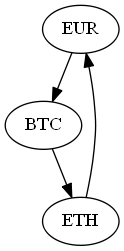

In [29]:
g1 = """digraph top {
   EUR -> BTC -> ETH-> EUR;
}"""
draw(g1)

In [85]:
#1 buy BTC sell EUR => BTCEUR ask
#2 buy ETH sell  BTC => ETHBTC ask
#3 sell ETH buy EUR => ETHEUR bid

ratioCW = (1./ask['BTCEUR'])*(1./ask['ETHBTC'])*(bid['ETHEUR'])
ratioCW
if ratioCW > 1.0:
	print 'Can make profits ratio is %f'%ratioCW
	syntheticBid = 1./((1./ask['BTCEUR'])*(1./ask['ETHBTC']))
	print '[1]send LMT buy ETHEUR@%f [bid=%f] '%(syntheticBid,bid['ETHEUR'])
	print '[2]If filled[1] send MKT sell BTCEUR(ask=%f)'%ask['BTCEUR']
	print '[2]If filled[1] send MKT sell ETHBTC(ask=%f)'%ask['ETHBTC']
else:
	print 'Price already adjusted=> no arbitrage oportunity'

Price already adjusted=> no arbitrage oportunity


In [61]:
1./((1./ask['BTCEUR'])*(1./ask['ETHBTC']))

250.39368

###  Counterclockwise : EUR->ETH->BTC

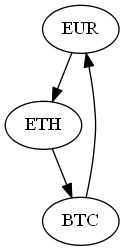

In [27]:
g1 = """digraph top {
   EUR -> ETH -> BTC-> EUR;
}"""
draw(g1)

In [87]:
#1 buy ETH sell EUR => ETHEUR bid
#2 buy BTC sell ETH => ETHBTC bid
#3 sell BTC buy EUR => BTCEUR ask

ratioCCW = (1.0/ask['ETHEUR'])*(bid['ETHBTC'])*(bid['BTCEUR'])
if ratioCCW > 1:
	print 'Can make profits ratio is %f'%ratioCCW
	syntheticBid =1./((1.0/ask['ETHEUR'])*(bid['ETHBTC']))
	print '[1]send LMT buy BTCEUR@%f [bid=%f]'%(syntheticBid,bid['BTCEUR'])
	print '[2]If filled[1] send MKT buy ETHEUR(ask=%f)'%ask['ETHEUR']
	print '[2]If filled[1] send MKT sell ETHBTC(bid=%f)'%bid['ETHBTC']
else:
	print 'Price already adjusted=> no arbitrage oportunity'

Can make profits ratio is 1.001382
[1]send LMT buy BTCEUR@3663.537694 [bid=3668.600000]
[2]If filled[1] send MKT buy ETHEUR(ask=249.780000)
[2]If filled[1] send MKT sell ETHBTC(bid=0.068180)
